# Private Multiplicative Weights for Histograms

In [4]:
using PrivateMultiplicativeWeights
using Distributions
using Plots
using CSV

In [5]:
using Random
Random.seed!(123) # Setting the seed

MersenneTwister(UInt32[0x0000007b], Random.DSFMT.DSFMT_state([1464307935, 1073116007, 222134151, 1073120226, -290652630, 1072956456, -580276323, 1073476387, 1332671753, 1073438661  …  138346874, 1073030449, 1049893279, 1073166535, -1999907543, 1597138926, -775229811, 32947490, 382, 0]), [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], UInt128[0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000  …  0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x00000000000000000000000000000000, 0x000000000000000000

## Input


We start from weights computed in Python (see Notebook `mwem_input_generator.ipynb`).

We load into the `Histogram` type from `PrivateMultiplicativeWeights.jl`

In [8]:
weights = CSV.read("binned_synthetic_weights.csv");
d = Vector(weights[:weight]);

┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = top-level scope at In[8]:2
└ @ Core In[8]:2


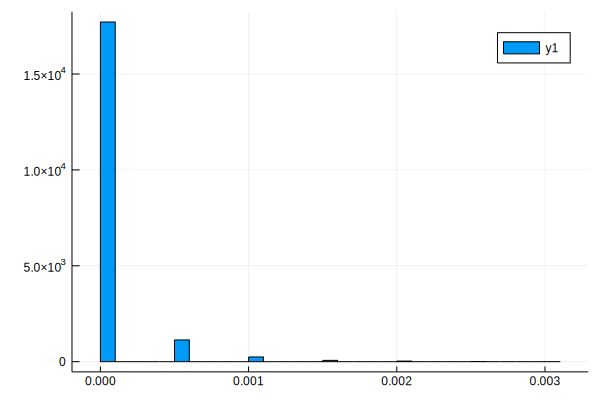

In [9]:
Plots.histogram(d, bins=50)

In [10]:
# Magic number is number of samples (Sourced from python notebook)
num_samples = 38462
h = Histogram(d, num_samples)

Histogram([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0005, 0.0005  …  0.0, 0.0, 0.0005, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], 38462)

Run the MWEM algorithm with different epsilon values and compute the mean squared error as a measure of utility.

In [11]:
epsilons = reverse([10.0^-n for n in range(1, stop=6)])
mses = []
max_errors = []

0-element Array{Any,1}

In [12]:
for ε in epsilons
    println("Running MWEM with ε=$ε")
    mw = mwem(SeriesRangeQueries(length(d)), h, MWParameters(epsilon=ε, iterations=50));
    mse = mean_squared_error(mw)
    println("Mean squared error = ", mse)
    append!(mses, mse)
end

Running MWEM with ε=1.0e-6
Mean squared error = 0.14611399841855893
Running MWEM with ε=1.0e-5
Mean squared error = 0.14852098103834627
Running MWEM with ε=0.0001
Mean squared error = 0.10523477279151656
Running MWEM with ε=0.001
Mean squared error = 0.0013385790171652598
Running MWEM with ε=0.01
Mean squared error = 4.440477470026448e-5
Running MWEM with ε=0.1
Mean squared error = 2.3215882595875074e-6


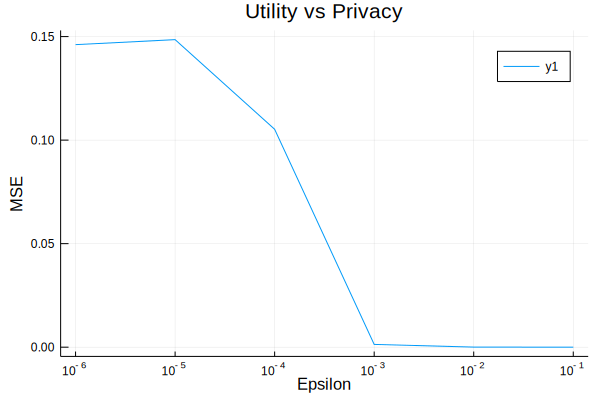

In [13]:
import Plots

Plots.plot(epsilons, mses, xlabel = "Epsilon", ylabel="MSE", title="Utility vs Privacy", xaxis=:log)

### Private histogram approximation

Using the MWEM algorithm we can generate synthetic and *differentially private* versions of the source histograms.

In [14]:
mwe = mwem(SeriesRangeQueries(length(d)), h, MWParameters(epsilon=1, iterations=50));
mwe1 = mwem(SeriesRangeQueries(length(d)), h, MWParameters(epsilon=0.1, iterations=50));
mwe01 = mwem(SeriesRangeQueries(length(d)), h, MWParameters(epsilon=0.01, iterations=50));


In [15]:
mwe02 = mwem(SeriesRangeQueries(length(d)), h, MWParameters(epsilon=0.002, iterations=50));

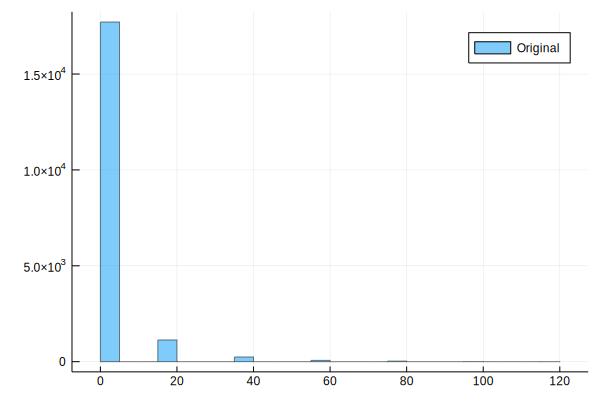

In [17]:
# The original (not protected) histogram
Plots.histogram(d*num_samples, bins=50, alpha = 0.5, label="Original")

Now we plot synthetic histograms using various epsilon values:

In [ ]:
Plots.histogram(mwe.synthetic.weights*num_samples, bins=50, alpha=0.5, label="Synthetic e=1")
Plots.histogram!(mwe1.synthetic.weights*num_samples, bins=50, alpha=0.5, label="Synthetic e=0.1")
Plots.histogram!(mwe01.synthetic.weights*num_samples, bins=50, alpha=0.1, label="Synthetic e=0.01")
#Plots.histogram!(mwe02.synthetic.weights*num_samples, bins=50, alpha=0.1, xlimit=[0, 1.0], label="Synthetic e=0.002")

# Compare protected vs unprotected distributions



In [18]:
function mses_from_weightfile(filename, num_samples)
    weights = CSV.read(filename)
    d = Vector(weights[:weight])
    # Magic number is number of samples (from python notebook)
    h = Histogram(d, num_samples)

    epsilons = reverse([10.0^-n for n in range(1, stop=4)])
    mses = []
    max_errors = []

    for ε in epsilons
        println("Running MWEM with ε=$ε")
        mw = mwem(SeriesRangeQueries(length(d)), h, MWParameters(epsilon=ε, iterations=10));
        mse = mean_squared_error(mw)
        println("Mean squared error = ", mse)
        append!(mses, mse)
    end
    return epsilons, mses
end

mses_from_weightfile (generic function with 1 method)

In [19]:
noprotection_fn = "unbinned_synthetic_weights.csv"
withprotection_fn = "binned_synthetic_weights.csv"

"binned_synthetic_weights.csv"

In [20]:
epsilons, mses = mses_from_weightfile(noprotection_fn, 2000)

Running MWEM with ε=0.0001


┌ Warning: `getindex(df::DataFrame, col_ind::ColumnIndex)` is deprecated, use `df[!, col_ind]` instead.
│   caller = mses_from_weightfile(::String, ::Int32) at In[18]:3
└ @ Main ./In[18]:3


Mean squared error = 0.2892160495660262
Running MWEM with ε=0.001
Mean squared error = 0.16437208566204065
Running MWEM with ε=0.01
Mean squared error = 0.004729819644350554
Running MWEM with ε=0.1
Mean squared error = 0.00021685944916705337


([0.0001, 0.001, 0.01, 0.1], Any[0.289216, 0.164372, 0.00472982, 0.000216859])

In [21]:
protected_epsilons, protected_mses = mses_from_weightfile(withprotection_fn, 2000)

Running MWEM with ε=0.0001
Mean squared error = 0.26518888964297616
Running MWEM with ε=0.001
Mean squared error = 0.2264762389743334
Running MWEM with ε=0.01
Mean squared error = 0.020205655437407613
Running MWEM with ε=0.1
Mean squared error = 0.00016491783081356792


([0.0001, 0.001, 0.01, 0.1], Any[0.265189, 0.226476, 0.0202057, 0.000164918])

In [26]:
[0.265189, 0.226476, 0.0202057, 0.000164918]./[0.289216, 0.164372, 0.00472982, 0.000216859]

4-element Array{Float64,1}:
 0.9169236833370216
 1.3778259070887988
 4.27198075191022  
 0.7604849233833967

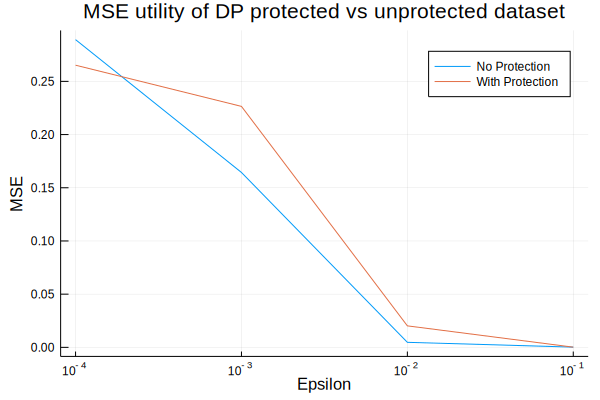

In [31]:
Plots.plot(epsilons, mses, 
    xlabel="Epsilon", 
    ylabel="MSE", 
    title="MSE utility of DP protected vs unprotected dataset", 
    label="No Protection", 
    xaxis=:log)

Plots.plot!(protected_epsilons, protected_mses, 
    xlabel="Epsilon", 
    ylabel="MSE", 
    label="With Protection", 
    xaxis=:log)